# <center style='color:red'>Train a Convolutional Neural Network (CNN) Using L1 and L2 Regularization- Example with `FashionMNIST` dataset</center>

## 1. Import the libraries

In [1]:
import torch
print('PyTorch version:', torch.__version__)

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

import torchvision
print('Torchvision version:', torchvision.__version__)

import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt

PyTorch version: 2.0.1+cu117
Torchvision version: 0.15.2+cu117


## 2. Define the device

In [2]:
print('GPU name:', torch.cuda.get_device_name(), '\n')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device is:', device, '\n')
print('Total number of GPUs:', torch.cuda.device_count())

GPU name: NVIDIA RTX A5000 

Device is: cuda 

Total number of GPUs: 1


## 3. Load `FashionMNIST` dataset

In [3]:
training_dataset = datasets.FashionMNIST('./data_src', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.FashionMNIST('./data_src', train=False, download=True, transform=transforms.ToTensor())

100%|██████████████████████████████████████████████| 26421880/26421880 [00:03<00:00, 6734196.38it/s]


Extracting ./data_src/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data_src/FashionMNIST/raw



100%|██████████████████████████████████████████████████████| 29515/29515 [00:00<00:00, 58740.63it/s]


Extracting ./data_src/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data_src/FashionMNIST/raw



100%|████████████████████████████████████████████████| 4422102/4422102 [00:02<00:00, 2111827.24it/s]


Extracting ./data_src/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data_src/FashionMNIST/raw



100%|██████████████████████████████████████████████████████| 5148/5148 [00:00<00:00, 6090910.29it/s]

Extracting ./data_src/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data_src/FashionMNIST/raw



In [4]:
# check the length of training and test datasets

print('Length of the training dataset:', len(training_dataset))
print('Length of the test dataset:', len(test_dataset))

Length of the training dataset: 60000
Length of the test dataset: 10000


##### In total, there are `60000 samples (images)` in the `training set` and `10000 samples (images)` in the `test set`.

In [5]:
# check the shape of training and test datasets

print('Shape of the training dataset:', training_dataset.data.shape)
print('Shape of the test dataset:', test_dataset.data.shape)

Shape of the training dataset: torch.Size([60000, 28, 28])
Shape of the test dataset: torch.Size([10000, 28, 28])


Shape: (total images, height, width)

##### The `spatial dimension` of the `grayscale images` in the `FashionMNIST` dataset is `28x28` pixels.

In [6]:
training_classes = training_dataset.classes
test_classes = test_dataset.classes

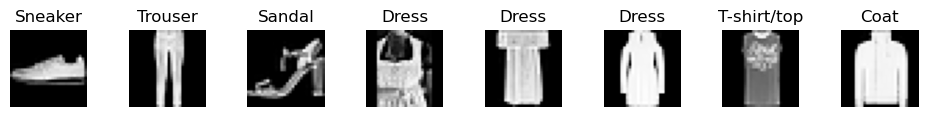

In [7]:
# show 8 randomly selected samples from the training dataset

fig, axis = plt.subplots(nrows=1, ncols=8, figsize=(12, 1))

for ax, _ in zip(axis.ravel(), range(8)):
    inx = np.random.randint(len(training_dataset))
    ax.imshow(training_dataset.data[inx], cmap='Greys_r')
    ax.set_title(training_classes[training_dataset.targets[inx]], fontsize=12)
    ax.axis(False);

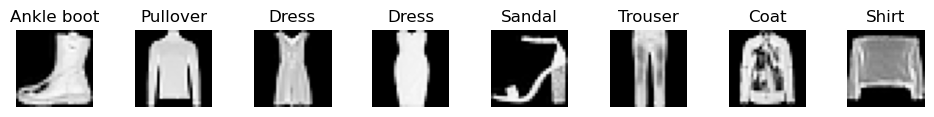

In [8]:
# show 8 randomly selected samples from the test dataset

fig, axis = plt.subplots(nrows=1, ncols=8, figsize=(12, 1))

for ax, _ in zip(axis.ravel(), range(8)):
    inx = np.random.randint(len(test_dataset))
    ax.imshow(test_dataset.data[inx], cmap='Greys_r')
    ax.set_title(test_classes[test_dataset.targets[inx]], fontsize=12)
    ax.axis(False);

## 4. Define dataloaders

In [9]:
training_dataloader = DataLoader(training_dataset, batch_size=32, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=True)

In [10]:
# check the length of training and test dataloaders

print('Length of the training dataloader:', len(training_dataloader))
print('Length of the test dataloader:', len(test_dataloader))

Length of the training dataloader: 1875
Length of the test dataloader: 312


Since, 10000 is not divisible by 32; the last batch will not have 32 images in it. I dropped the `last_batch` from both the training and test dataloaders. 227 and 62 are showing the number of batches in training and test dataloaders, respectively.

##### Dataloader converts a dataset into an iterable.

## 5. Define the network architecture

In [11]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.f_e = nn.Sequential()
        self.f_e.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=64, kernel_size=4, stride=2, padding=1))
        self.f_e.add_module('bnorm1', nn.BatchNorm2d(num_features=64))
        self.f_e.add_module('pooling1', nn.MaxPool2d(kernel_size=2, stride=2))
        self.f_e.add_module('relu1', nn.ReLU(inplace=True))
        self.f_e.add_module('conv2', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1))
        self.f_e.add_module('bnorm2', nn.BatchNorm2d(num_features=128))
        self.f_e.add_module('pooling2', nn.MaxPool2d(kernel_size=2, stride=2))
        self.f_e.add_module('relu2', nn.ReLU(inplace=True))
        
        self.c_l = nn.Sequential()
        self.c_l.add_module('linear1', nn.Linear(in_features=512, out_features=256))
        self.c_l.add_module('dropout1', nn.Dropout(p=0.5))
        self.c_l.add_module('linear2', nn.Linear(in_features=256, out_features=128))
        self.c_l.add_module('dropout2', nn.Dropout(p=0.5))
        self.c_l.add_module('linear3', nn.Linear(in_features=128, out_features=10))
        
    def forward(self, x):
        x = self.f_e(x)
        x = x.view(x.shape[0], -1)
        x = self.c_l(x)
        return x

## 6. Visualize the model architecture

In [12]:
model = CNN().to(device)
summary(model, input_size=(32, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [32, 10]                  --
├─Sequential: 1-1                        [32, 128, 2, 2]           --
│    └─Conv2d: 2-1                       [32, 64, 14, 14]          1,088
│    └─BatchNorm2d: 2-2                  [32, 64, 14, 14]          128
│    └─MaxPool2d: 2-3                    [32, 64, 7, 7]            --
│    └─ReLU: 2-4                         [32, 64, 7, 7]            --
│    └─Conv2d: 2-5                       [32, 128, 4, 4]           73,856
│    └─BatchNorm2d: 2-6                  [32, 128, 4, 4]           256
│    └─MaxPool2d: 2-7                    [32, 128, 2, 2]           --
│    └─ReLU: 2-8                         [32, 128, 2, 2]           --
├─Sequential: 1-2                        [32, 10]                  --
│    └─Linear: 2-9                       [32, 256]                 131,328
│    └─Dropout: 2-10                     [32, 256]                 --
│

## 7. Define the training batch

In [13]:
def training_batch(data, labels, model, criterion, optimizer):
    model.train()
    data = data.to(device)
    labels = labels.to(device)
    output = model(data)
    loss = criterion(output, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

## 8. Define the test batch

In [14]:
with torch.inference_mode():
    def test_batch(data, labels, model, criterion):
        model.eval()
        data = data.to(device)
        labels = labels.to(device)
        output = model(data)
        loss = criterion(output, labels)
        return loss

## 9. Define the accuracy function

In [15]:
with torch.inference_mode():
    def accuracy(data, labels, model):
        model.eval()
        data = data.to(device)
        labels = labels.to(device)
        output = model(data)
        _, pred_labels = output.max(-1)
        correct = (pred_labels == labels)
        return correct.cpu().detach().numpy().tolist()

## 10. Set up model (`CNN`), criterion (`loss function`) and optimizer

In [16]:
cnn = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)

## 11. Train the model

In [17]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

n_epochs = 10

training_loss, test_loss = [], []
training_accuracy, test_accuracy = [], []

for epoch in range(n_epochs):
    training_losses, test_losses = [], []
    training_accuracies, test_accuracies = [], []
    
    for data, labels in training_dataloader:
        trng_batch_loss = training_batch(data, labels, cnn, criterion, optimizer)
        training_losses.append(trng_batch_loss.item())
        trng_batch_correct = accuracy(data, labels, cnn)
        training_accuracies.extend(trng_batch_correct)
    training_per_epoch_loss = np.array(training_losses).mean()
    training_per_epoch_accuracy = np.mean(training_accuracies)
    
    for data, labels in test_dataloader:
        tst_batch_loss = test_batch(data, labels, cnn, criterion)
        test_losses.append(tst_batch_loss.item())
        tst_batch_correct = accuracy(data, labels, cnn)
        test_accuracies.extend(tst_batch_correct)
    test_per_epoch_loss = np.array(test_losses).mean()
    test_per_epoch_accuracy = np.mean(test_accuracies)
    
    training_loss.append(training_per_epoch_loss)
    training_accuracy.append(training_per_epoch_accuracy)
    test_loss.append(test_per_epoch_loss)
    test_accuracy.append(test_per_epoch_accuracy)
    
    print(f'Epoch: {epoch+1}/{n_epochs}\t| Training loss: {training_per_epoch_loss:.4f} | ', end='')
    print(f'Training accuracy: {training_per_epoch_accuracy:.4f} | Test loss: {test_per_epoch_loss:.4f} | ', end='')
    print(f'Test accuracy: {test_per_epoch_accuracy:.4f}')

Epoch: 1/10	| Training loss: 0.5262 | Training accuracy: 0.8509 | Test loss: 0.3407 | Test accuracy: 0.8781
Epoch: 2/10	| Training loss: 0.3642 | Training accuracy: 0.8952 | Test loss: 0.3363 | Test accuracy: 0.8754
Epoch: 3/10	| Training loss: 0.3178 | Training accuracy: 0.9089 | Test loss: 0.3102 | Test accuracy: 0.8909
Epoch: 4/10	| Training loss: 0.2898 | Training accuracy: 0.9179 | Test loss: 0.2902 | Test accuracy: 0.8992
Epoch: 5/10	| Training loss: 0.2691 | Training accuracy: 0.9240 | Test loss: 0.3025 | Test accuracy: 0.8986
Epoch: 6/10	| Training loss: 0.2513 | Training accuracy: 0.9293 | Test loss: 0.2868 | Test accuracy: 0.8990
Epoch: 7/10	| Training loss: 0.2367 | Training accuracy: 0.9336 | Test loss: 0.2923 | Test accuracy: 0.8944
Epoch: 8/10	| Training loss: 0.2238 | Training accuracy: 0.9393 | Test loss: 0.2844 | Test accuracy: 0.9005
Epoch: 9/10	| Training loss: 0.2142 | Training accuracy: 0.9424 | Test loss: 0.3030 | Test accuracy: 0.9027
Epoch: 10/10	| Training loss

## 12. Plot model loss and accuracy

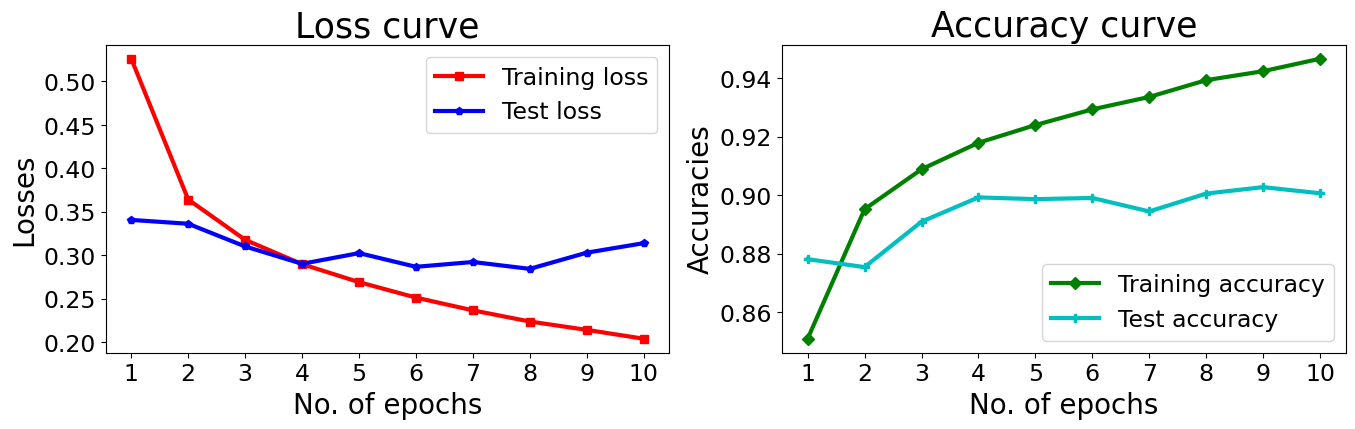

In [18]:
N = np.arange(10) + 1

fig = plt.figure(figsize=(16, 4))

fig.add_subplot(1, 2, 1)
plt.plot(N, training_loss, 'r-s', linewidth=3, label='Training loss')
plt.plot(N, test_loss, 'b-p', linewidth=3, label='Test loss')
plt.title('Loss curve', fontsize=25)
plt.xlabel('No. of epochs', fontsize=20)
plt.ylabel('Losses', fontsize=20)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], fontsize=17)
plt.yticks(fontsize=17)
plt.legend(fontsize=17)

fig.add_subplot(1, 2, 2)
plt.plot(N, training_accuracy, 'g-D', linewidth=3, label='Training accuracy')
plt.plot(N, test_accuracy, 'c-P', linewidth=3, label='Test accuracy')
plt.title('Accuracy curve', fontsize=25)
plt.xlabel('No. of epochs', fontsize=20)
plt.ylabel('Accuracies', fontsize=20)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], fontsize=17)
plt.yticks(fontsize=17)
plt.legend(fontsize=17);

We can see that after 8 epochs, the test loss starts increasing while the training loss is gradually decreasing. This is the case of __overfitting__.

## 13. Model prediction

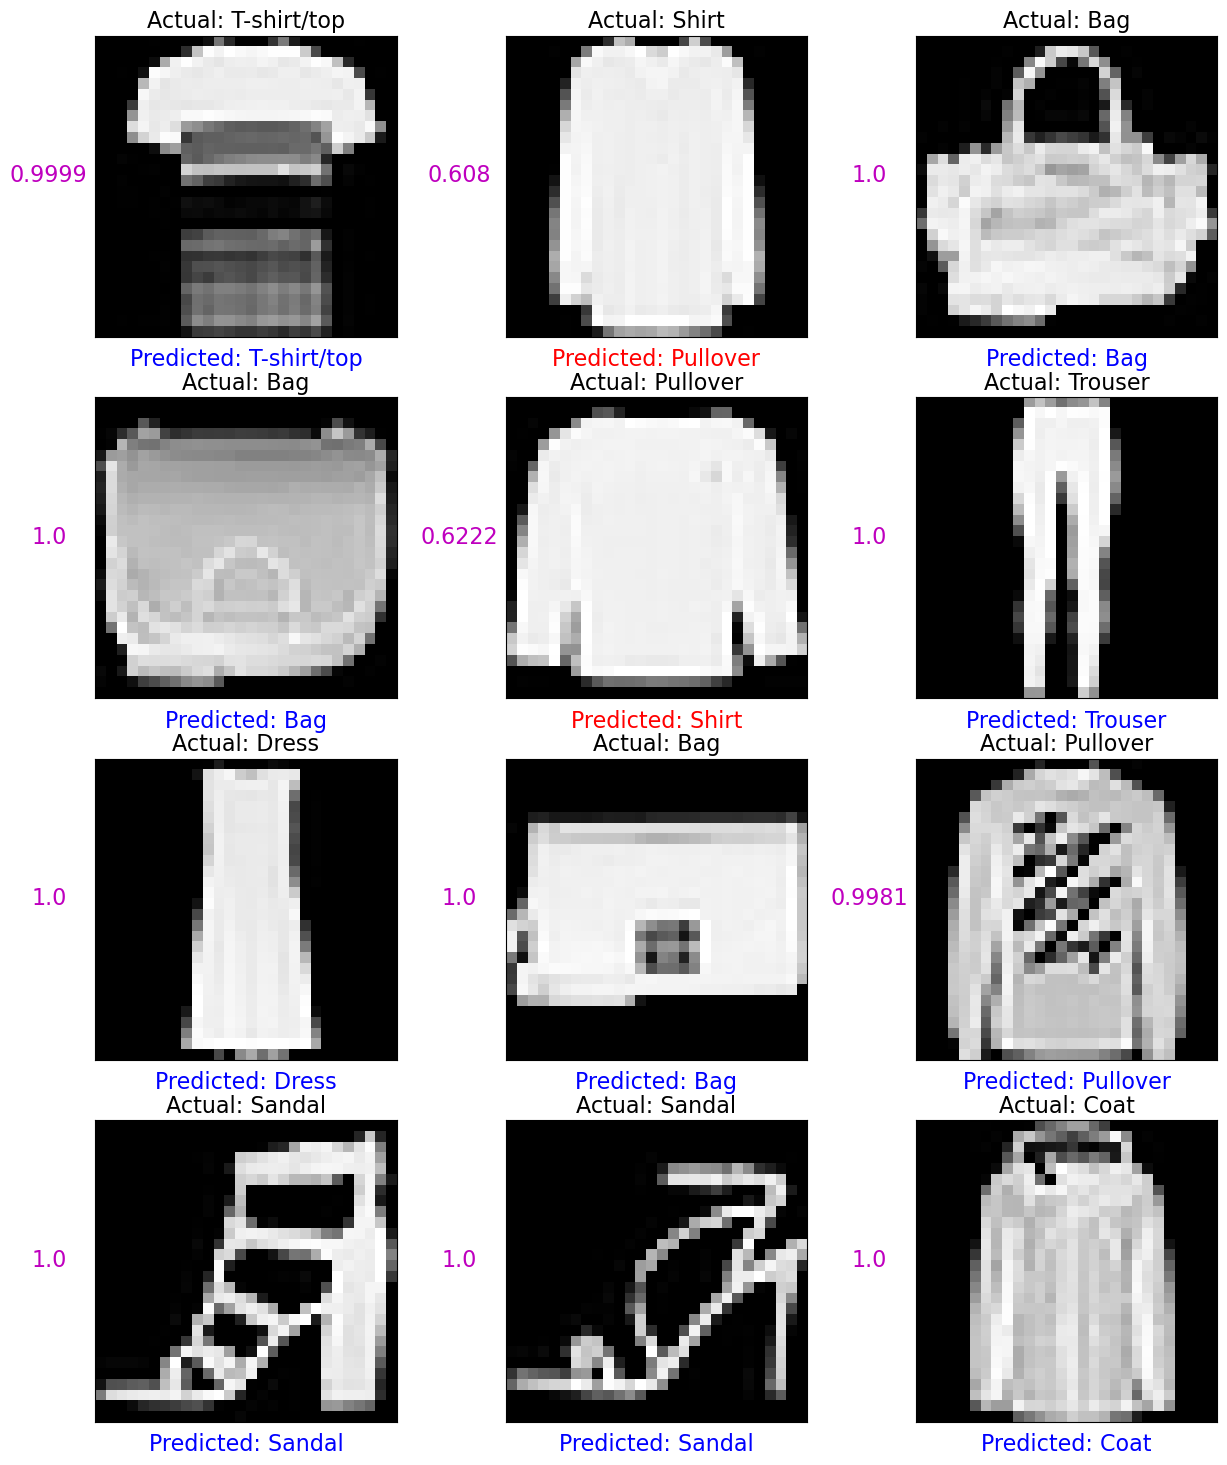

In [19]:
SAMPLES, PREDS, LABELS = [], [], []

for a in range(12):
    idx = np.random.randint(len(test_dataset))
    SAMPLES.append(test_dataset[idx])
    output = F.softmax(cnn.cpu()(SAMPLES[a][0].unsqueeze(0)), dim=-1)
    pred_values, pred_labels = output.max(-1)
    PREDS.append(round(float(pred_values), 4))
    LABELS.append(int(pred_labels))

fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(15, 18))
i = 0
for R in range(4):
    for C in range(3):
        ax[R, C].imshow(torch.clamp(SAMPLES[i][0], min=0, max=1).permute(1, 2, 0), cmap='Greys_r')
        ax[R, C].set_title('Actual: ' + test_classes[SAMPLES[i][1]], fontsize=16).set_color('k') # actual labels
        if SAMPLES[i][1] == LABELS[i]:
            ax[R, C].set_xlabel('Predicted: ' + test_classes[LABELS[i]], fontsize=16).set_color('b') # correct predictions
        else:
            ax[R, C].set_xlabel('Predicted: ' + test_classes[LABELS[i]], fontsize=16).set_color('r') # wrong predictions
        ax[R, C].set_ylabel(PREDS[i], fontsize=16, rotation=0, labelpad=30).set_color('m') # probability of predicted class
        ax[R, C].set_xticks([])
        ax[R, C].set_yticks([])
        i += 1

We are randomly selecting 12 images from the test set and checking the model prediction on them.

## 14. Define the training batch with `L1` regularization

In [20]:
def training_batch_L1(data, labels, model, criterion, optimizer):
    model.train()
    data = data.to(device)
    labels = labels.to(device)
    output = model(data)
    loss = criterion(output, labels)
    
    # L1 regularization
    alpha = 0.001
    l1_norm = sum(param.abs().sum() for param in model.parameters())
    LOSS = loss + alpha * l1_norm
    
    optimizer.zero_grad()
    LOSS.backward()
    optimizer.step()
    return LOSS

## 15. Set up model (`CNN`), criterion (`loss function`) and optimizer [for `L1` regularization]

In [21]:
cnn = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)

## 16. Train the model considering `L1` regularization

In [22]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

n_epochs = 10

training_loss, test_loss = [], []
training_accuracy, test_accuracy = [], []

for epoch in range(n_epochs):
    training_losses, test_losses = [], []
    training_accuracies, test_accuracies = [], []
    
    for data, labels in training_dataloader:
        trng_batch_loss = training_batch_L1(data, labels, cnn, criterion, optimizer)
        training_losses.append(trng_batch_loss.item())
        trng_batch_correct = accuracy(data, labels, cnn)
        training_accuracies.extend(trng_batch_correct)
    training_per_epoch_loss = np.array(training_losses).mean()
    training_per_epoch_accuracy = np.mean(training_accuracies)
    
    for data, labels in test_dataloader:
        tst_batch_loss = test_batch(data, labels, cnn, criterion)
        test_losses.append(tst_batch_loss.item())
        tst_batch_correct = accuracy(data, labels, cnn)
        test_accuracies.extend(tst_batch_correct)
    test_per_epoch_loss = np.array(test_losses).mean()
    test_per_epoch_accuracy = np.mean(test_accuracies)
    
    training_loss.append(training_per_epoch_loss)
    training_accuracy.append(training_per_epoch_accuracy)
    test_loss.append(test_per_epoch_loss)
    test_accuracy.append(test_per_epoch_accuracy)
    
    print(f'Epoch: {epoch+1}/{n_epochs}\t| Training loss: {training_per_epoch_loss:.4f} | ', end='')
    print(f'Training accuracy: {training_per_epoch_accuracy:.4f} | Test loss: {test_per_epoch_loss:.4f} | ', end='')
    print(f'Test accuracy: {test_per_epoch_accuracy:.4f}')

Epoch: 1/10	| Training loss: 1.9712 | Training accuracy: 0.8086 | Test loss: 0.5163 | Test accuracy: 0.8214
Epoch: 2/10	| Training loss: 1.1737 | Training accuracy: 0.8517 | Test loss: 0.4481 | Test accuracy: 0.8385
Epoch: 3/10	| Training loss: 1.0418 | Training accuracy: 0.8643 | Test loss: 0.4396 | Test accuracy: 0.8361
Epoch: 4/10	| Training loss: 0.9886 | Training accuracy: 0.8711 | Test loss: 0.3993 | Test accuracy: 0.8603
Epoch: 5/10	| Training loss: 0.9505 | Training accuracy: 0.8730 | Test loss: 0.4242 | Test accuracy: 0.8511
Epoch: 6/10	| Training loss: 0.9214 | Training accuracy: 0.8757 | Test loss: 0.3951 | Test accuracy: 0.8613
Epoch: 7/10	| Training loss: 0.9025 | Training accuracy: 0.8762 | Test loss: 0.3915 | Test accuracy: 0.8606
Epoch: 8/10	| Training loss: 0.8844 | Training accuracy: 0.8792 | Test loss: 0.3946 | Test accuracy: 0.8591
Epoch: 9/10	| Training loss: 0.8770 | Training accuracy: 0.8788 | Test loss: 0.3827 | Test accuracy: 0.8608
Epoch: 10/10	| Training loss

## 17. Plot model loss and accuracy considering `L1` regularization

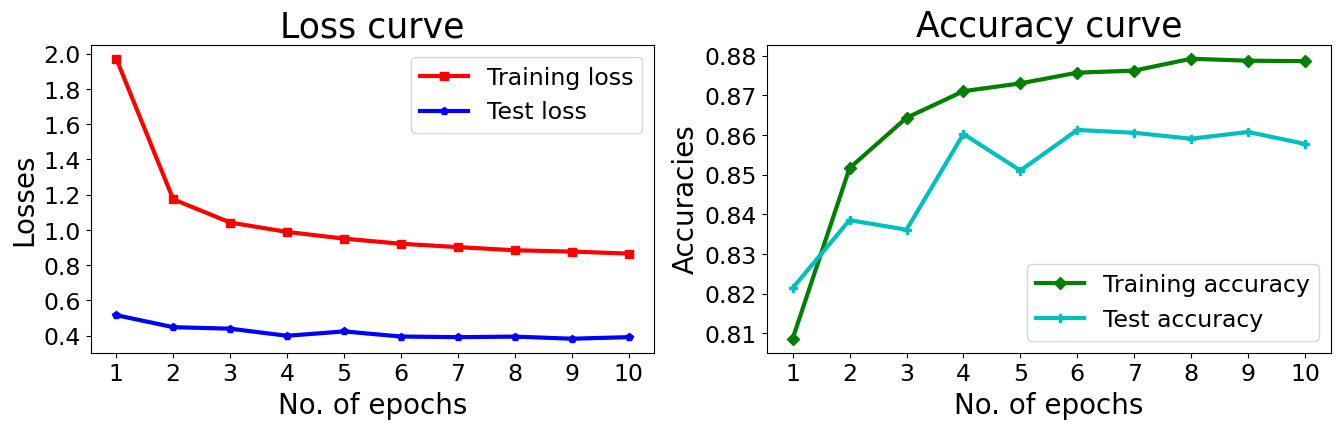

In [23]:
N = np.arange(10) + 1

fig = plt.figure(figsize=(16, 4))

fig.add_subplot(1, 2, 1)
plt.plot(N, training_loss, 'r-s', linewidth=3, label='Training loss')
plt.plot(N, test_loss, 'b-p', linewidth=3, label='Test loss')
plt.title('Loss curve', fontsize=25)
plt.xlabel('No. of epochs', fontsize=20)
plt.ylabel('Losses', fontsize=20)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], fontsize=17)
plt.yticks(fontsize=17)
plt.legend(fontsize=17)

fig.add_subplot(1, 2, 2)
plt.plot(N, training_accuracy, 'g-D', linewidth=3, label='Training accuracy')
plt.plot(N, test_accuracy, 'c-P', linewidth=3, label='Test accuracy')
plt.title('Accuracy curve', fontsize=25)
plt.xlabel('No. of epochs', fontsize=20)
plt.ylabel('Accuracies', fontsize=20)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], fontsize=17)
plt.yticks(fontsize=17)
plt.legend(fontsize=17);

We can see that both the training loss and the test loss are gradually decreasing. The difference between the training accuracy and the test accuracy is also smaller compared to the results without any regularization.

## 18. Model prediction considering `L1` regularization

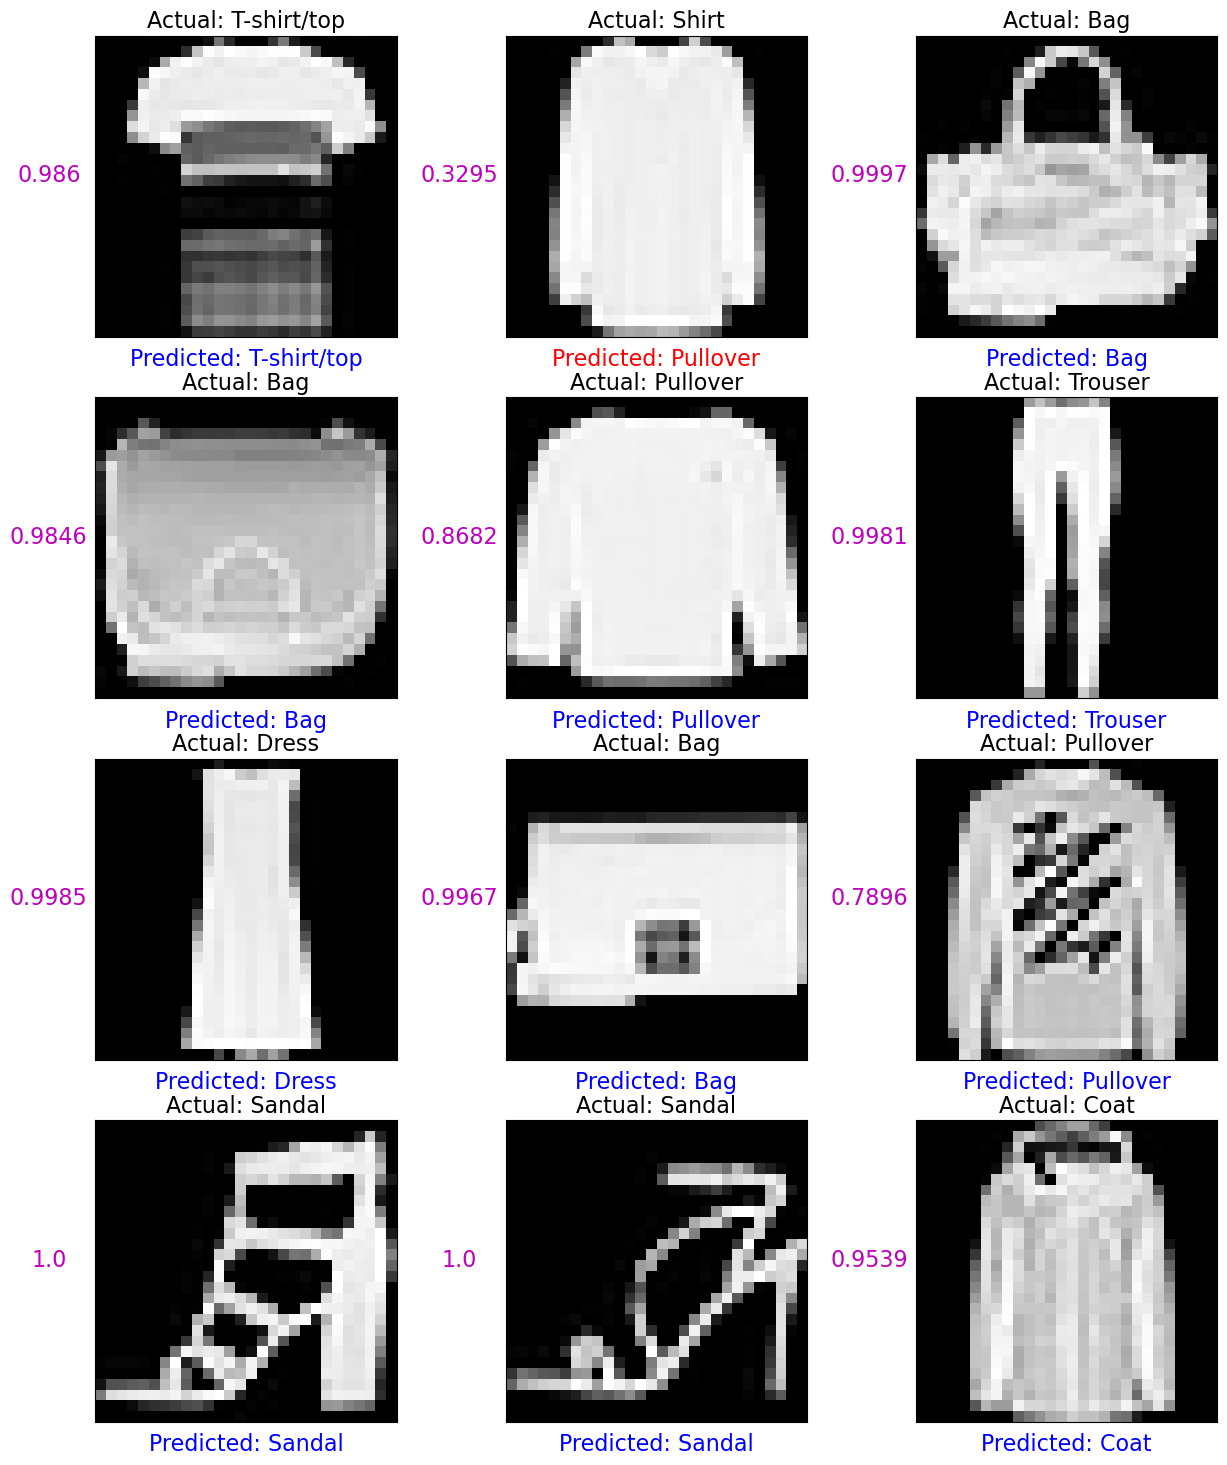

In [24]:
SAMPLES, PREDS, LABELS = [], [], []

for a in range(12):
    idx = np.random.randint(len(test_dataset))
    SAMPLES.append(test_dataset[idx])
    output = F.softmax(cnn.cpu()(SAMPLES[a][0].unsqueeze(0)), dim=-1)
    pred_values, pred_labels = output.max(-1)
    PREDS.append(round(float(pred_values), 4))
    LABELS.append(int(pred_labels))

fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(15, 18))
i = 0
for R in range(4):
    for C in range(3):
        ax[R, C].imshow(torch.clamp(SAMPLES[i][0], min=0, max=1).permute(1, 2, 0), cmap='Greys_r')
        ax[R, C].set_title('Actual: ' + test_classes[SAMPLES[i][1]], fontsize=16).set_color('k') # actual labels
        if SAMPLES[i][1] == LABELS[i]:
            ax[R, C].set_xlabel('Predicted: ' + test_classes[LABELS[i]], fontsize=16).set_color('b') # correct predictions
        else:
            ax[R, C].set_xlabel('Predicted: ' + test_classes[LABELS[i]], fontsize=16).set_color('r') # wrong predictions
        ax[R, C].set_ylabel(PREDS[i], fontsize=16, rotation=0, labelpad=30).set_color('m') # probability of predicted class
        ax[R, C].set_xticks([])
        ax[R, C].set_yticks([])
        i += 1

We are randomly selecting 12 images from the test set and checking the model prediction on them by taking `L1` regularization in consideration.

## 19. Define the training batch with `L2` regularization

In [25]:
def training_batch_L2(data, labels, model, criterion, optimizer):
    model.train()
    data = data.to(device)
    labels = labels.to(device)
    output = model(data)
    loss = criterion(output, labels)
    
    # L2 regularization
    alpha = 0.001
    l2_norm = sum(param.pow(2).sum() for param in model.parameters())
    LOSS = loss + alpha * l2_norm
    
    optimizer.zero_grad()
    LOSS.backward()
    optimizer.step()
    return LOSS

## 20. Set up model (`CNN`), criterion (`loss function`) and optimizer [for `L2` regularization]

In [26]:
cnn = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)

## 21. Train the model considering `L2` regularization

In [27]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

n_epochs = 10

training_loss, test_loss = [], []
training_accuracy, test_accuracy = [], []

for epoch in range(n_epochs):
    training_losses, test_losses = [], []
    training_accuracies, test_accuracies = [], []
    
    for data, labels in training_dataloader:
        trng_batch_loss = training_batch_L2(data, labels, cnn, criterion, optimizer)
        training_losses.append(trng_batch_loss.item())
        trng_batch_correct = accuracy(data, labels, cnn)
        training_accuracies.extend(trng_batch_correct)
    training_per_epoch_loss = np.array(training_losses).mean()
    training_per_epoch_accuracy = np.mean(training_accuracies)
    
    for data, labels in test_dataloader:
        tst_batch_loss = test_batch(data, labels, cnn, criterion)
        test_losses.append(tst_batch_loss.item())
        tst_batch_correct = accuracy(data, labels, cnn)
        test_accuracies.extend(tst_batch_correct)
    test_per_epoch_loss = np.array(test_losses).mean()
    test_per_epoch_accuracy = np.mean(test_accuracies)
    
    training_loss.append(training_per_epoch_loss)
    training_accuracy.append(training_per_epoch_accuracy)
    test_loss.append(test_per_epoch_loss)
    test_accuracy.append(test_per_epoch_accuracy)
    
    print(f'Epoch: {epoch+1}/{n_epochs}\t| Training loss: {training_per_epoch_loss:.4f} | ', end='')
    print(f'Training accuracy: {training_per_epoch_accuracy:.4f} | Test loss: {test_per_epoch_loss:.4f} | ', end='')
    print(f'Test accuracy: {test_per_epoch_accuracy:.4f}')

Epoch: 1/10	| Training loss: 0.8475 | Training accuracy: 0.8483 | Test loss: 0.3773 | Test accuracy: 0.8706
Epoch: 2/10	| Training loss: 0.6225 | Training accuracy: 0.8873 | Test loss: 0.3755 | Test accuracy: 0.8654
Epoch: 3/10	| Training loss: 0.5640 | Training accuracy: 0.8952 | Test loss: 0.3822 | Test accuracy: 0.8636
Epoch: 4/10	| Training loss: 0.5350 | Training accuracy: 0.9003 | Test loss: 0.3292 | Test accuracy: 0.8783
Epoch: 5/10	| Training loss: 0.5177 | Training accuracy: 0.9035 | Test loss: 0.3204 | Test accuracy: 0.8891
Epoch: 6/10	| Training loss: 0.5053 | Training accuracy: 0.9051 | Test loss: 0.3104 | Test accuracy: 0.8915
Epoch: 7/10	| Training loss: 0.4928 | Training accuracy: 0.9066 | Test loss: 0.3355 | Test accuracy: 0.8723
Epoch: 8/10	| Training loss: 0.4849 | Training accuracy: 0.9088 | Test loss: 0.3401 | Test accuracy: 0.8781
Epoch: 9/10	| Training loss: 0.4810 | Training accuracy: 0.9092 | Test loss: 0.3201 | Test accuracy: 0.8900
Epoch: 10/10	| Training loss

## 22. Plot model loss and accuracy considering `L2` regularization

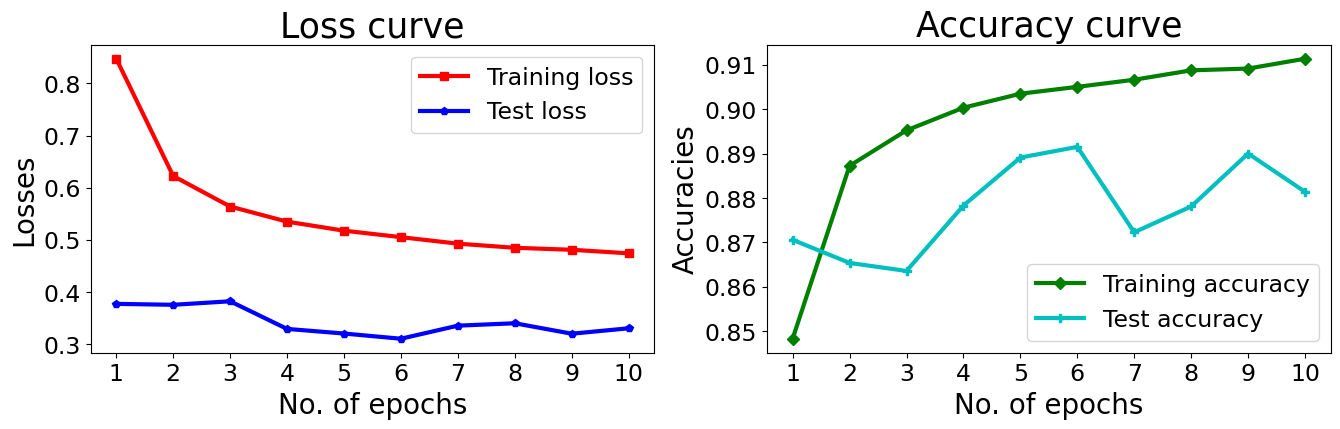

In [28]:
N = np.arange(10) + 1

fig = plt.figure(figsize=(16, 4))

fig.add_subplot(1, 2, 1)
plt.plot(N, training_loss, 'r-s', linewidth=3, label='Training loss')
plt.plot(N, test_loss, 'b-p', linewidth=3, label='Test loss')
plt.title('Loss curve', fontsize=25)
plt.xlabel('No. of epochs', fontsize=20)
plt.ylabel('Losses', fontsize=20)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], fontsize=17)
plt.yticks(fontsize=17)
plt.legend(fontsize=17)

fig.add_subplot(1, 2, 2)
plt.plot(N, training_accuracy, 'g-D', linewidth=3, label='Training accuracy')
plt.plot(N, test_accuracy, 'c-P', linewidth=3, label='Test accuracy')
plt.title('Accuracy curve', fontsize=25)
plt.xlabel('No. of epochs', fontsize=20)
plt.ylabel('Accuracies', fontsize=20)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], fontsize=17)
plt.yticks(fontsize=17)
plt.legend(fontsize=17);

We can see that both the training loss and the test loss are gradually decreasing. The difference between these two losses is much lower compared to what we obtained using `L1` regularization. The difference between the training accuracy and the test accuracy is also smaller compared to the results without any regularization. Moreover, the training accuracy and the test accuracy values are higher in comparison to `L1` regularization.

## 23. Model prediction considering `L2` regularization

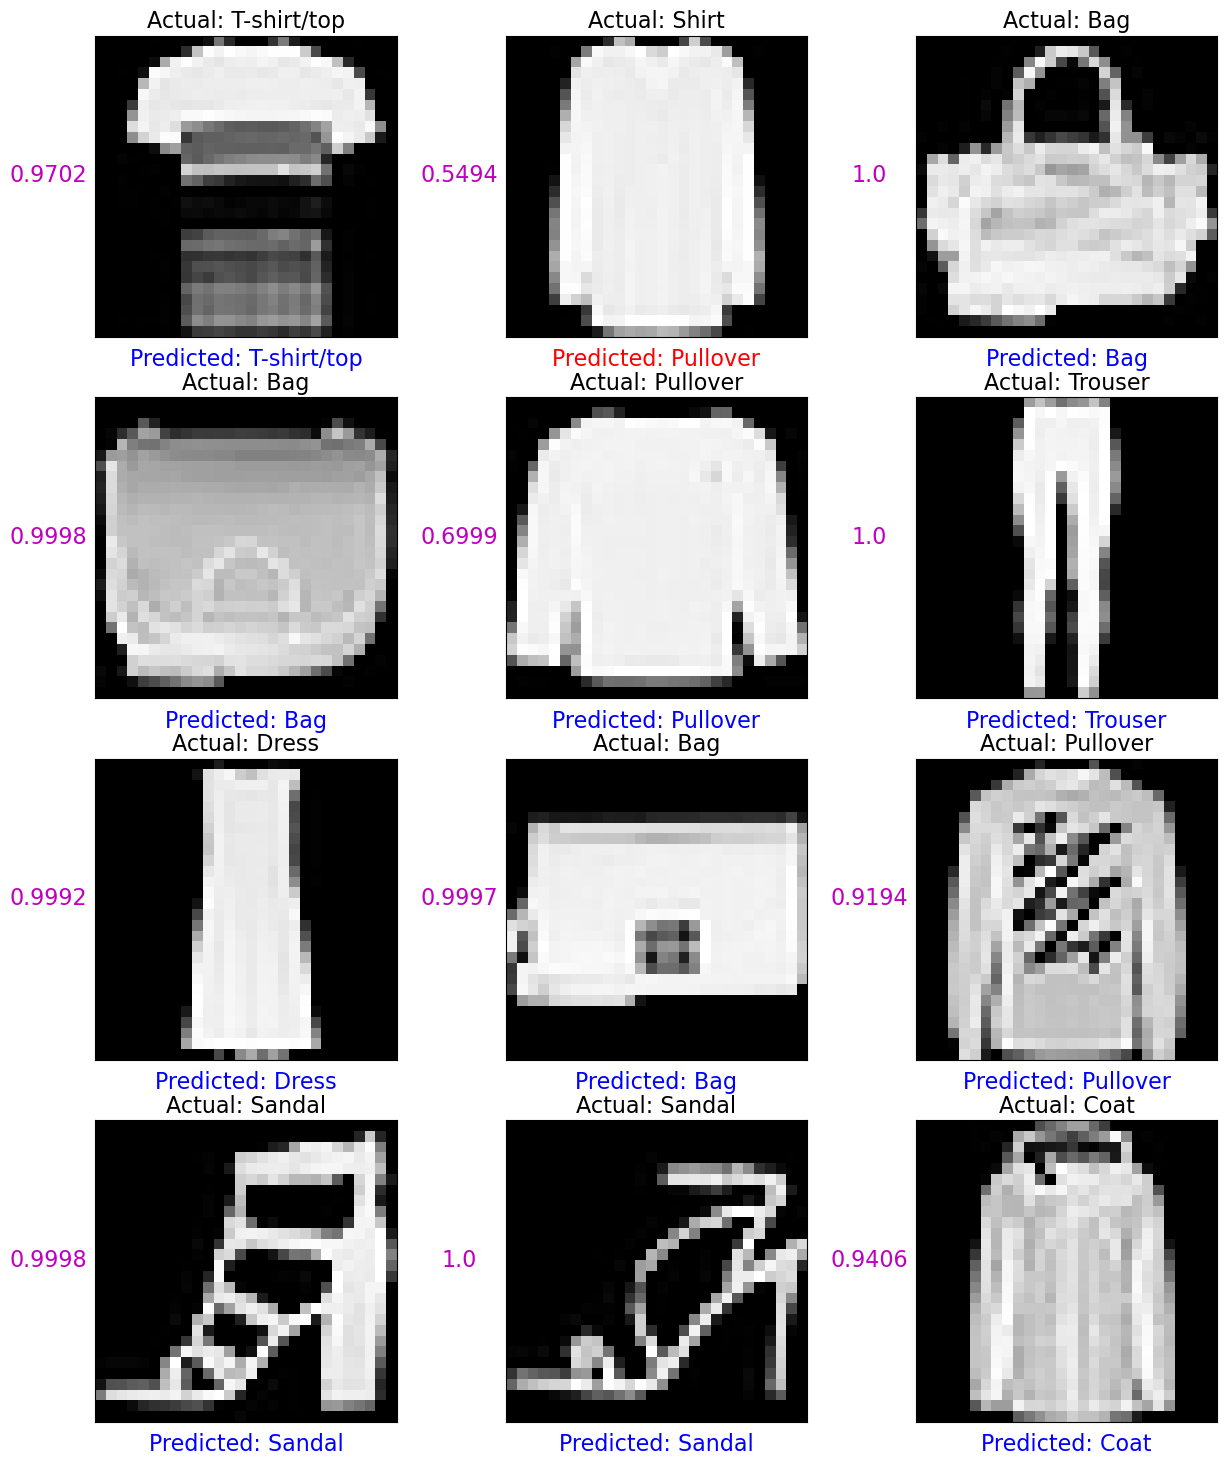

In [29]:
SAMPLES, PREDS, LABELS = [], [], []

for a in range(12):
    idx = np.random.randint(len(test_dataset))
    SAMPLES.append(test_dataset[idx])
    output = F.softmax(cnn.cpu()(SAMPLES[a][0].unsqueeze(0)), dim=-1)
    pred_values, pred_labels = output.max(-1)
    PREDS.append(round(float(pred_values), 4))
    LABELS.append(int(pred_labels))

fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(15, 18))
i = 0
for R in range(4):
    for C in range(3):
        ax[R, C].imshow(torch.clamp(SAMPLES[i][0], min=0, max=1).permute(1, 2, 0), cmap='Greys_r')
        ax[R, C].set_title('Actual: ' + test_classes[SAMPLES[i][1]], fontsize=16).set_color('k') # actual labels
        if SAMPLES[i][1] == LABELS[i]:
            ax[R, C].set_xlabel('Predicted: ' + test_classes[LABELS[i]], fontsize=16).set_color('b') # correct predictions
        else:
            ax[R, C].set_xlabel('Predicted: ' + test_classes[LABELS[i]], fontsize=16).set_color('r') # wrong predictions
        ax[R, C].set_ylabel(PREDS[i], fontsize=16, rotation=0, labelpad=30).set_color('m') # probability of predicted class
        ax[R, C].set_xticks([])
        ax[R, C].set_yticks([])
        i += 1

We are randomly selecting 12 images from the test set and checking the model prediction on them by taking `L2` regularization in consideration.